# Predicción de Atraso en Despegues

### 0. Ambiente local de desarrollo

El ambiente de desarrollo local fue configurado utilizando las siguientes herramientas:

+ **Poetry** versión 1.1.13
+ **Pyenv** versión 2.3.3
+ **Virtualenv** versión 20.16.4

El ambiente virtual se activa con el siguiente comando: 

+ **source .venv/bin/activate**

### 1. Librerias 

In [38]:
#### Análisis exploratorio #################
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt

#### Configuración #########################
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

### 2. Descripción del Dataset 

El dataset describe los despegues y los datos relacionados al vuelo desde el terminal aéreo de Santiago (SCL)

### 2.1 Descripción de las columnas

1. **Fecha-I** : Fecha y hora programada del vuelo. 
2. **Vlo-I**   : Número de vuelo programado.
3. **Ori-I**   : Código de ciudad de origen programado. 
4. **Des-I**   : Código de ciudad de destino programado. 
5. **Emp-I**   : Código aerolínea de vuelo programado. 
6. **Fecha-O** : Fecha y hora de operación del vuelo.
7. **Vlo-O**   : Número de vuelo de operación del vuelo.
8. **Ori-O**   : Código de ciudad de origen de operación.
9. .**Des-O**  : Código de ciudad de destino de operación.
10. **Emp-O**  : Código aerolínea de vuelo operado.
11. **DIA**    : Día del mes de operación del vuelo.
12. **MES**    : Número de mes de operación del vuelo.
13. **AÑO**       : Año de operación del vuelo.
14. **DIANOM**    : Día de la semana de operación del vuelo. 
15. **TIPOVUELO** : Tipo de vuelo, I =Internacional, N =Nacional. 
16. **OPERA**     : Nombre de aerolínea que opera.
16. **SIGLAORI**  : Nombre ciudad origen.
17. **SIGLADES**  : Nombre ciudad destino.

### 3. Carga datos 

In [39]:
# Definición ruta acceso a los datos

DATA = Path('/Users/claudiocollaobahamondes/Desktop/desafio/pred_atraso_vuelos/data')

# Validación si existe la carpeta data
DATA.exists()

True

In [40]:
# Por definición se fuerza a las columnas Fecha-I y Fecha-O tengan formato de fecha cuando se cargan los datos

df=pd.read_csv(DATA/'dataset_SCL.csv',parse_dates=['Fecha-I','Fecha-O'],infer_datetime_format=True)

In [41]:
# Tamaño del datset

df.shape

(68206, 18)

In [42]:
# Validación de los formatos por columna

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68206 non-null  object        
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68205 non-null  object        
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int64         
 11  MES        68206 non-null  int64         
 12  AÑO        68206 non-null  int64         
 13  DIANOM     68206 non-null  object        
 14  TIPOVUELO  68206 non-null  object        
 15  OPERA      68206 non-null  object        
 16  SIGLAORI   68206 non-null  object       

In [43]:
# Los números de vuelo se confirmará que son variables  categóricas

df['Vlo-I'] = df['Vlo-I'].apply(lambda x: str(x))
df['Vlo-O'] = df['Vlo-O'].apply(lambda x: str(x))

 **Comentarios carga de los datos**

 No se modificará el formato del resto de las variables dado que aquellas que identifican el vuelo es correcto el formato categorico y las relacionadas con la fecha del vuelo es correcto que sean numéricas.

### 4. Análisis Exploratorio

### 4.1 Análisis Variables Categóricas

In [44]:
# Creación dataset con variables categóricas

categoricas = df.select_dtypes(include=[object])

In [45]:
# Columnas dataset variables categóricas

categoricas.columns

Index(['Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Vlo-O', 'Ori-O', 'Des-O', 'Emp-O',
       'DIANOM', 'TIPOVUELO', 'OPERA', 'SIGLAORI', 'SIGLADES'],
      dtype='object')

In [46]:
#Visualización muestra de las variables categóricas

categoricas.head()

,Vlo-I,Ori-I,Des-I,Emp-I,Vlo-O,Ori-O,Des-O,Emp-O,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,226,SCEL,KMIA,AAL,226,SCEL,KMIA,AAL,Domingo,I,American Airlines,Santiago,Miami
1,226,SCEL,KMIA,AAL,226,SCEL,KMIA,AAL,Lunes,I,American Airlines,Santiago,Miami
2,226,SCEL,KMIA,AAL,226,SCEL,KMIA,AAL,Martes,I,American Airlines,Santiago,Miami
3,226,SCEL,KMIA,AAL,226,SCEL,KMIA,AAL,Miercoles,I,American Airlines,Santiago,Miami
4,226,SCEL,KMIA,AAL,226,SCEL,KMIA,AAL,Jueves,I,American Airlines,Santiago,Miami


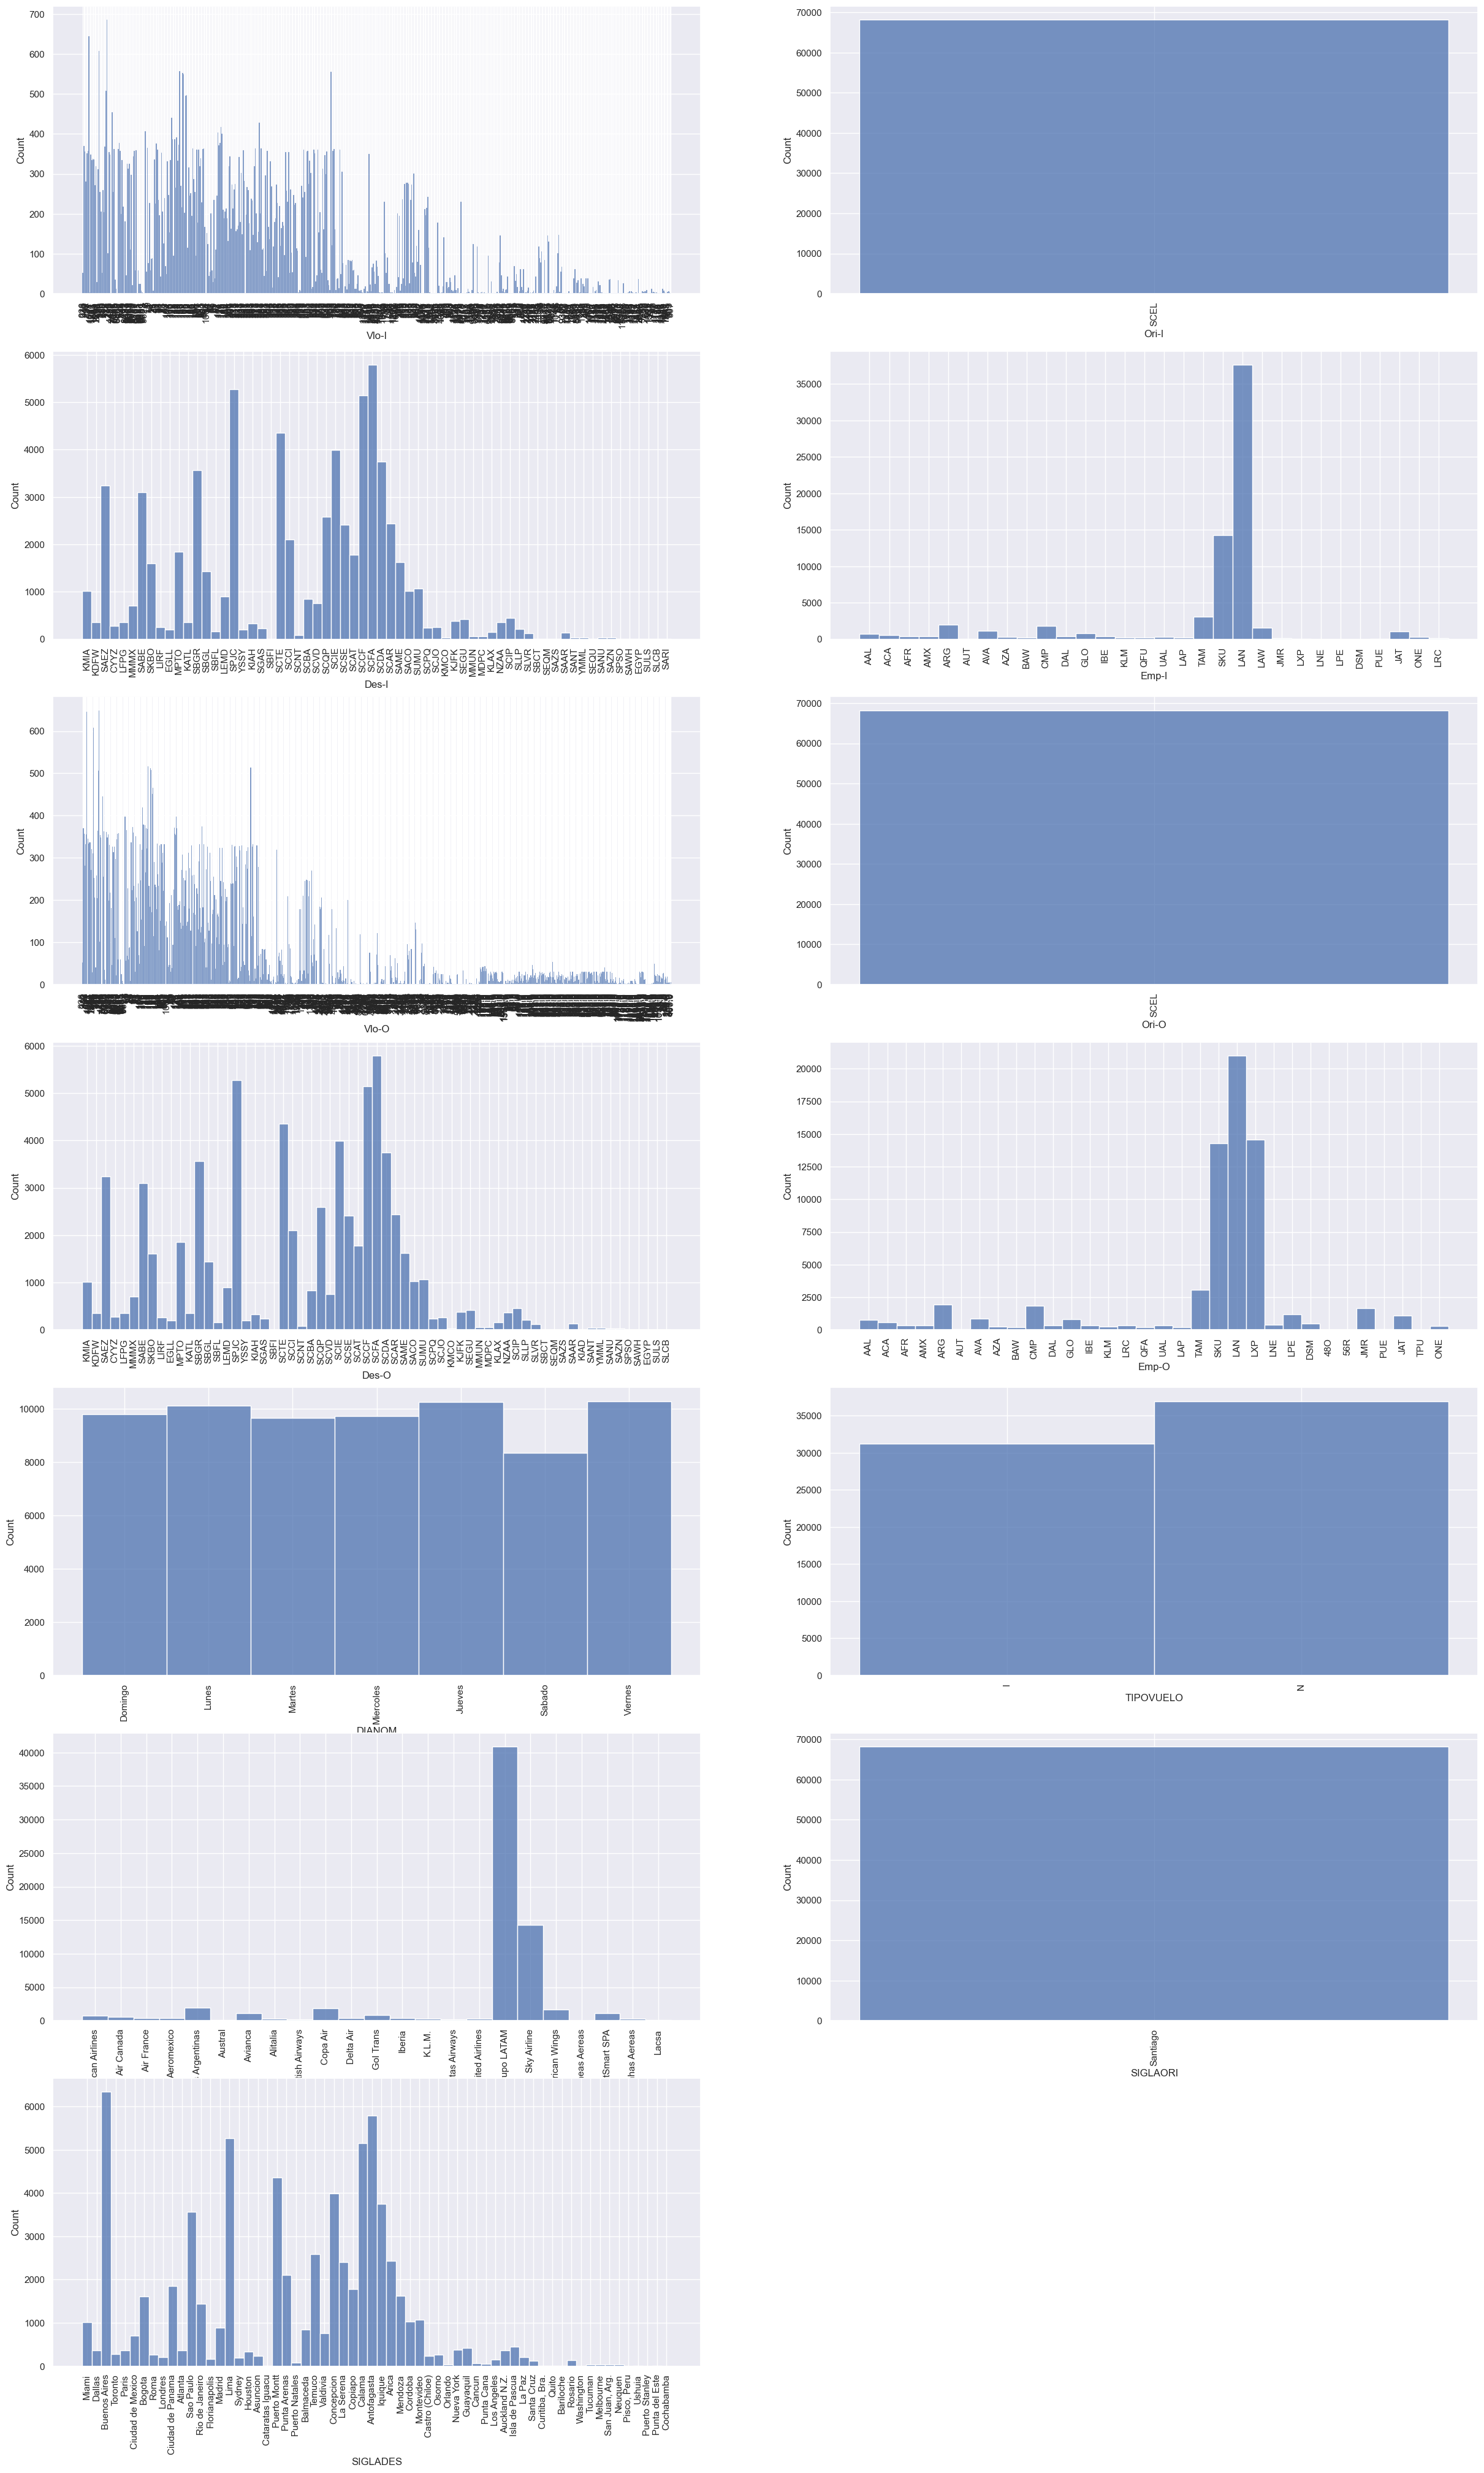

In [118]:
# Visualización variables categóricas


plt.figure(figsize=(30,50))

for i,col in enumerate(categoricas.columns,1):
    plt.subplot(7,2,i)
    sns.histplot(data=categoricas, x=col)
    plt.xticks(rotation=90)
plt.show()

In [48]:
# Validación que los datos de origen y destino en las variables destino,
# número de vuelo y empresa que realiza el vuelo.

df['diff_des'] = np.where(df['Des-I'] == df['Des-O'],1,0)
df['diff_vlo'] = np.where(df['Vlo-I'] == df['Vlo-O'],1,0)
df['diff_emp'] = np.where(df['Emp-I'] == df['Emp-O'],1,0)

In [49]:
# Cantidad de destinos operados distintos al programado

df['diff_des'].value_counts()

1    68178
0       28
Name: diff_des, dtype: int64

In [50]:
# Cantidad 

df['diff_vlo'].value_counts()

1    63687
0     4519
Name: diff_vlo, dtype: int64

In [51]:
#

df['diff_emp'].value_counts()

1    49537
0    18669
Name: diff_emp, dtype: int64

In [52]:
# Validación entre la empresa planificada y la que opero el vuelo.

df.groupby(['Emp-I','Emp-O','OPERA']).agg({'OPERA':'count'})

OPERA
Emp-I Emp-O OPERA                          
AAL   AAL   American Airlines           757
ACA   ACA   Air Canada                  565
AFR   AFR   Air France                  358
AMX   AMX   Aeromexico                  351
ARG   ARG   Aerolineas Argentinas      1944
      AUT   Aerolineas Argentinas         5
AUT   ARG   Austral                       2
      AUT   Austral                      72
AVA   AVA   Avianca                     885
      LRC   Avianca                     265
      TPU   Avianca                       2
AZA   AZA   Alitalia                    259
BAW   BAW   British Airways             205
CMP   CMP   Copa Air                   1850
DAL   DAL   Delta Air                   358
DSM   DSM   Grupo LATAM                   2
GLO   GLO   Gol Trans                   806
IBE   IBE   Iberia                      362
JAT   JAT   JetSmart SPA               1095
JMR   JMR   Latin American Wings        100
KLM   KLM   K.L.M.                      251
LAN   DSM   Grupo LATAM                 491
      LAN   Grupo LATAM               20988
      LNE   Grupo LATAM                 373
      LPE   Grupo LATAM                1210
      LXP   Grupo LATAM               14549
LAP   LAP   Grupo LATAM                 216
LAW   48O   Latin American Wings         10
      56R   Latin American Wings         17
      JMR   Latin American Wings       1547
LNE   LNE   Grupo LATAM                   1
LPE   LPE   Grupo LATAM                   4
LRC   LRC   Lacsa                        92
LXP   LXP   Grupo LATAM                   9
ONE   ONE   Oceanair Linhas Aereas      279
PUE   PUE   Plus Ultra Lineas Aereas     49
QFU   QFA   Qantas Airways              195
SKU   SKU   Sky Airline               14298
TAM   LAP   Grupo LATAM                   3
      TAM   Grupo LATAM                3046
UAL   UAL   United Airlines             335

In [53]:
# Validación columna Des-o y SiglaDes

df.groupby(['Des-O','SIGLADES']).agg({'SIGLADES':'count'})

,,SIGLADES
Des-O,SIGLADES,
CYYZ,Toronto,283
EGLL,Londres,205
EGYP,Puerto Stanley,1
KATL,Atlanta,358
KDFW,Dallas,357
...,...,...
SPSO,"Pisco, Peru",1
SULS,Punta del Este,6
SUMU,Montevideo,1066


### 4.2 Análisis Variables Numéricas

In [54]:
numericas = df.select_dtypes(include=[int])

In [55]:
numericas.columns[:3]

Index(['DIA', 'MES', 'AÑO'], dtype='object')

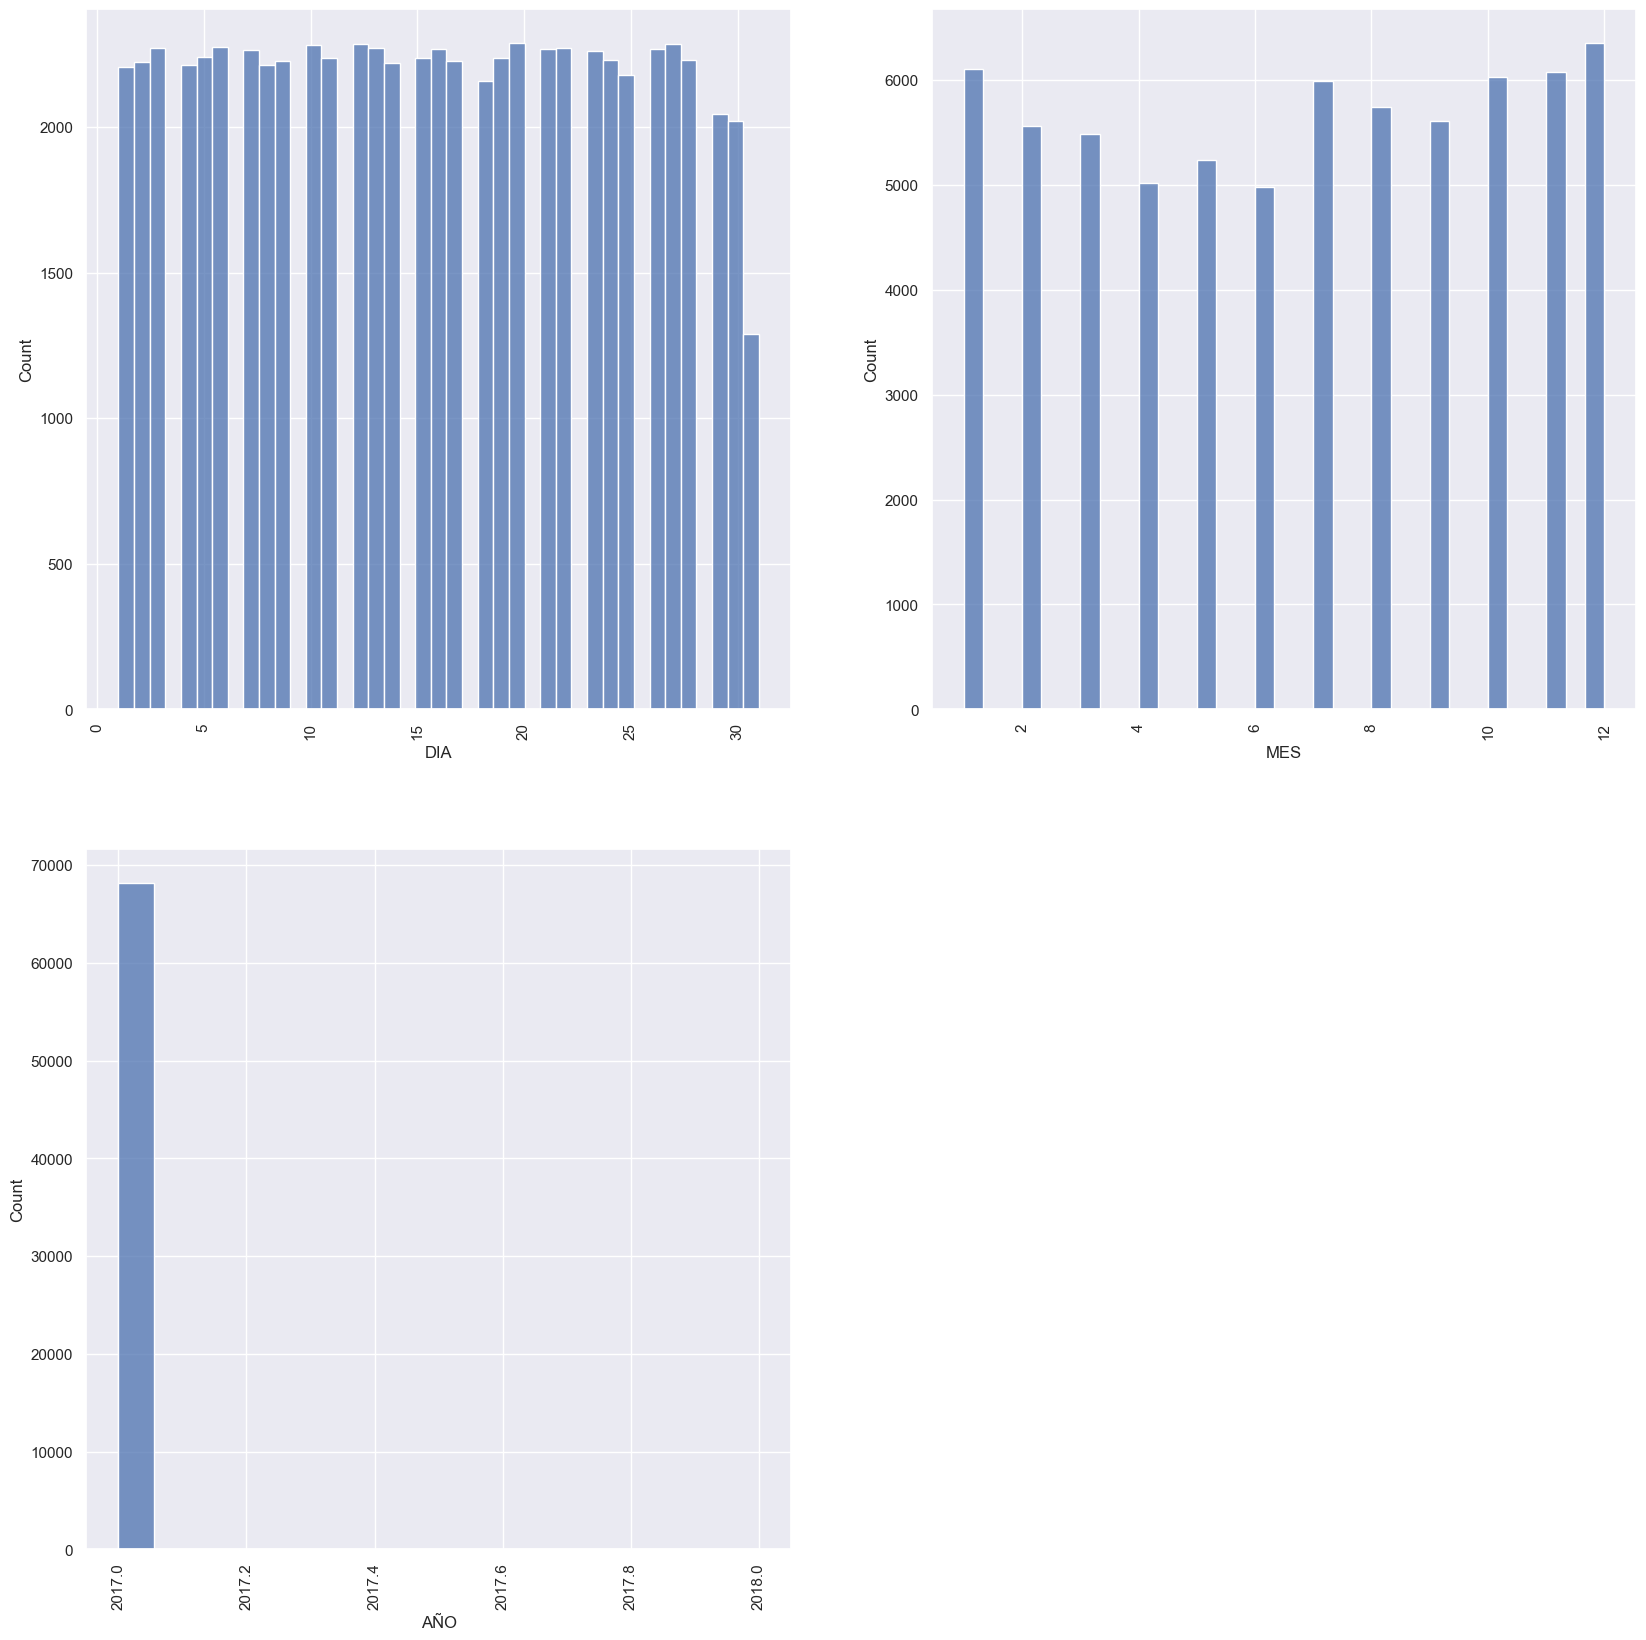

In [56]:
# Visualización variables númericas

plt.figure(figsize=(20,20))

for i,col in enumerate(numericas.columns[:3],1):
    plt.subplot(2,2,i)
    sns.histplot(data=numericas, x=col)
    plt.xticks(rotation=90)

### 4.3 Generación de la variable objetivo 

In [57]:
# Generar la diferencia en minutos entre la fecha y hora programada y real

df['diff_min'] = (df['Fecha-O'] - df['Fecha-I'])/datetime.timedelta(minutes=1)
df['atraso_15'] = df['diff_min'].apply(lambda x: 1 if x>15 else 0)

### 4.4 Análisis Variable Objetivo

In [58]:
# Frecuencia relativa de las clases en la variable objetivo

df['atraso_15'].value_counts(normalize=True)

0    0.81506
1    0.18494
Name: atraso_15, dtype: float64

In [ ]:
Una hipotesis es que las clases desbalanceadas afectan el modelo

Text(0.5, 1.0, 'Frecuencia Clases Variable Objetivo')

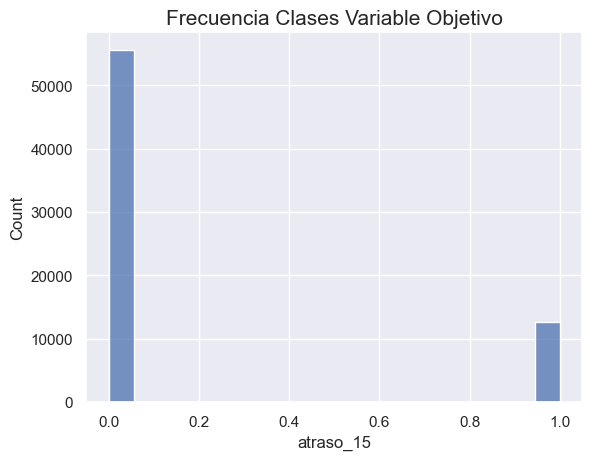

In [121]:
# Visualización frecuencia clases variable objetivo

sns.histplot(data=df, x='atraso_15')
plt.title('Frecuencia Clases Variable Objetivo', fontsize=15)

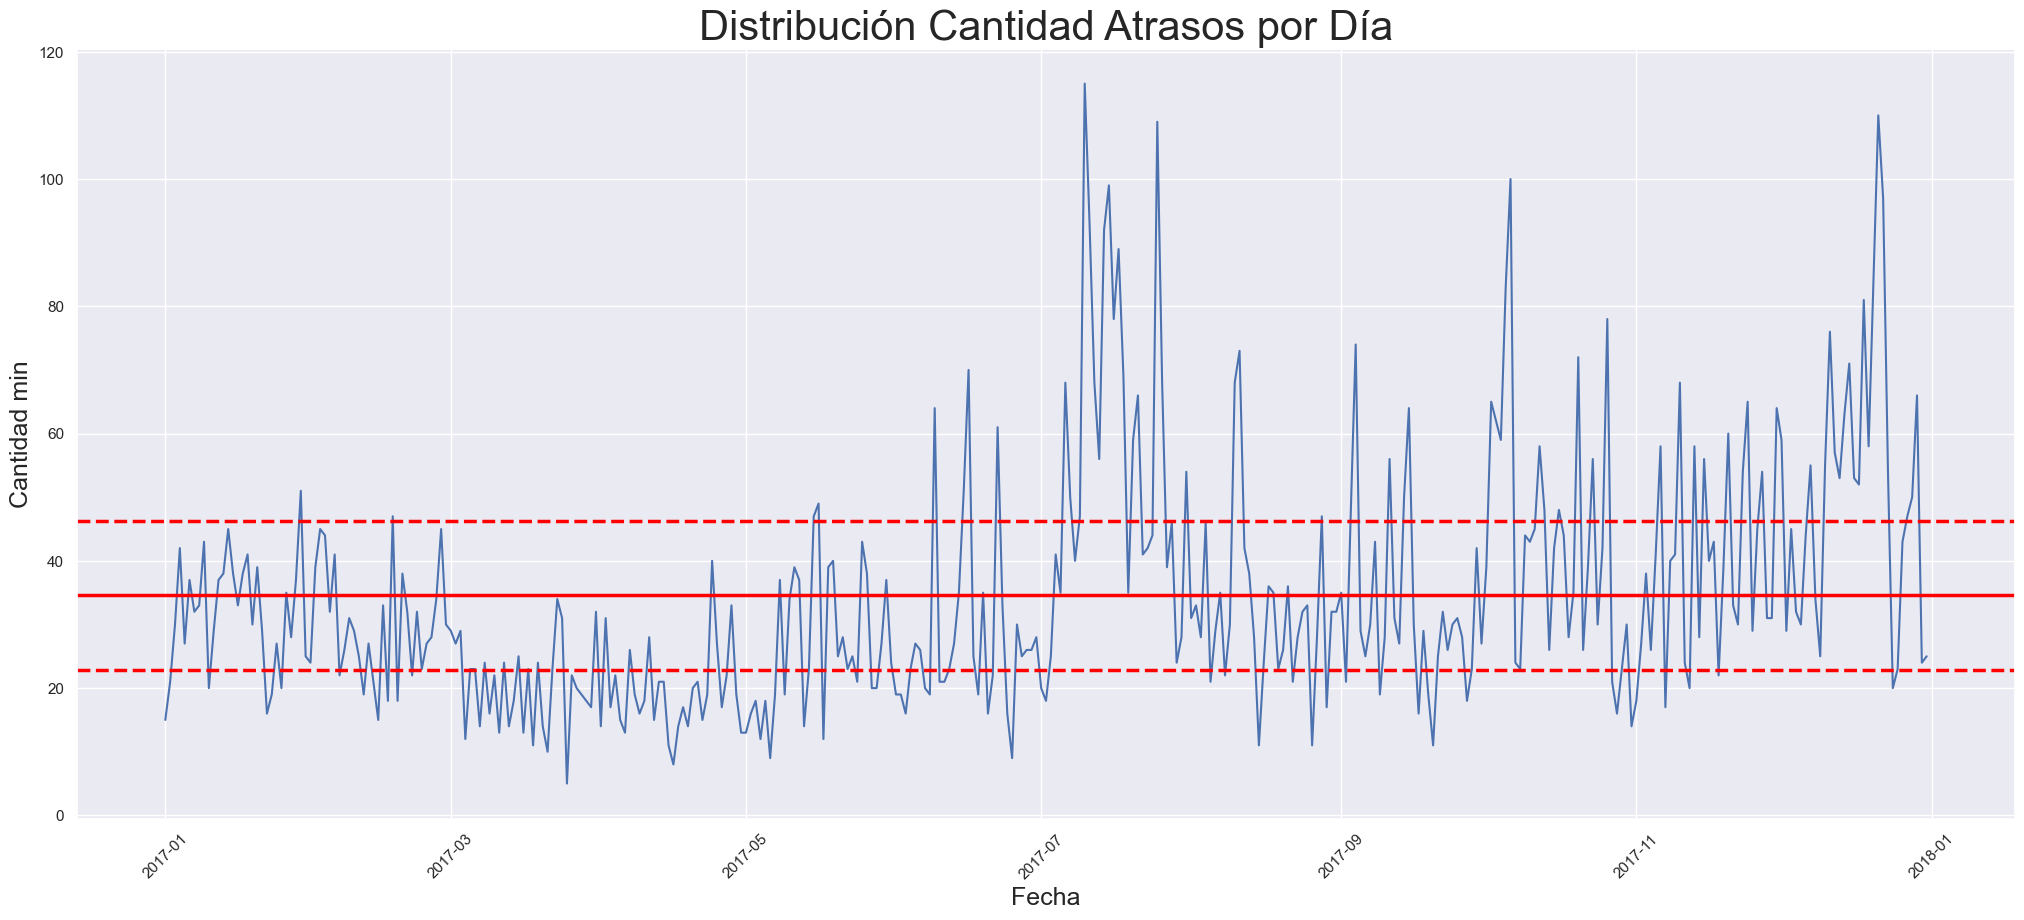

In [139]:
# Distribución de la cantidad de atrasos por día.

retrasos = df[df['diff_min']>0]
retrasos_cant = retrasos.groupby('Fecha-I').agg({'atraso_15':'sum'}).reset_index()
retrasos_cant.set_index('Fecha-I',inplace=True)
retrasos_cant = retrasos_cant.resample('D').sum()


m = np.mean(retrasos_cant['atraso_15'])
sd = np.std(retrasos_cant['atraso_15'])

ci_low = m - (1.96*sd / np.sqrt(10))
ci_high = m + (1.96*sd / np.sqrt(10))

plt.figure(figsize=(25,10))
sns.lineplot(data=retrasos_cant, x="Fecha-I", y='atraso_15')
plt.axhline(y=m,
            color='red',
            ls='-', 
            lw=2.5)
plt.axhline(y=ci_low,
            color='red',
            ls='--', 
            lw=2.5)
plt.axhline(y=ci_high,
            color='red',
            ls='--', 
            lw=2.5)
plt.xlabel('Fecha', fontsize=18);
plt.ylabel('Cantidad min', fontsize=18);
plt.title('Distribución Cantidad Atrasos por Día', fontsize=30)
plt.xticks(rotation=45)
plt.show()

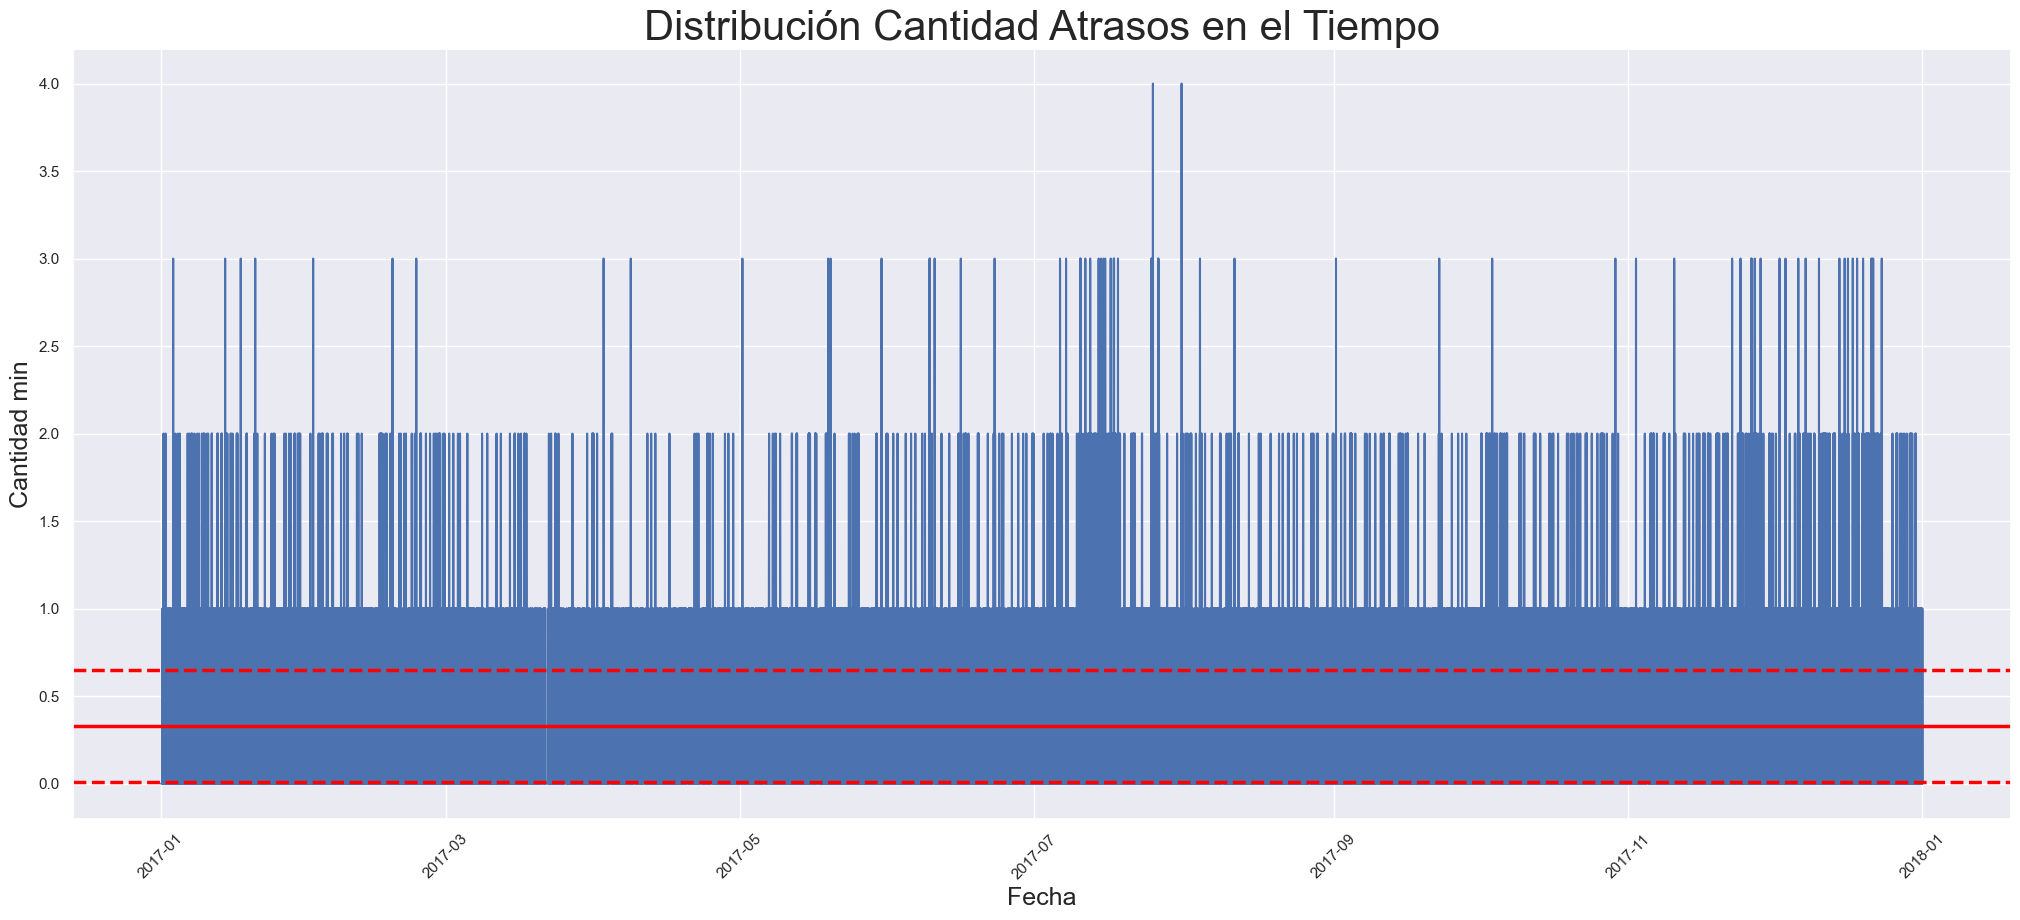

In [138]:
# Distribución de la cantidad de atrasos por día.

retrasos = df[df['diff_min']>0]
retrasos_cant = retrasos.groupby('Fecha-I').agg({'atraso_15':'sum'}).reset_index()
retrasos_cant.set_index('Fecha-I',inplace=True)
#retrasos_cant = retrasos_cant.resample('D').sum()


m = np.mean(retrasos_cant['atraso_15'])
sd = np.std(retrasos_cant['atraso_15'])

ci_low = m - (1.96*sd / np.sqrt(10))
ci_high = m + (1.96*sd / np.sqrt(10))

plt.figure(figsize=(25,10))
sns.lineplot(data=retrasos_cant, x="Fecha-I", y='atraso_15')
plt.axhline(y=m,
            color='red',
            ls='-', 
            lw=2.5)
plt.axhline(y=ci_low,
            color='red',
            ls='--', 
            lw=2.5)
plt.axhline(y=ci_high,
            color='red',
            ls='--', 
            lw=2.5)
plt.xlabel('Fecha', fontsize=18);
plt.ylabel('Cantidad min', fontsize=18);
plt.title('Distribución Cantidad Atrasos en el Tiempo', fontsize=30)
plt.xticks(rotation=45)
plt.show()

### 4.4 Análisis Exploratorio Considerando Variable Objetivo

In [86]:
# ¿Qué linea área es la que más se retrasa?


atrasos_emp = df.groupby('OPERA').agg({'atraso_15':'sum'})
atrasos_emp.reset_index(inplace=True)
atrasos_emp = atrasos_emp.sort_values(by='atraso_15',ascending=False)
 
atrasos_emp.head()

,OPERA,atraso_15
12,Grupo LATAM,7306
21,Sky Airline,2540
17,Latin American Wings,681
0,Aerolineas Argentinas,468
7,Avianca,306


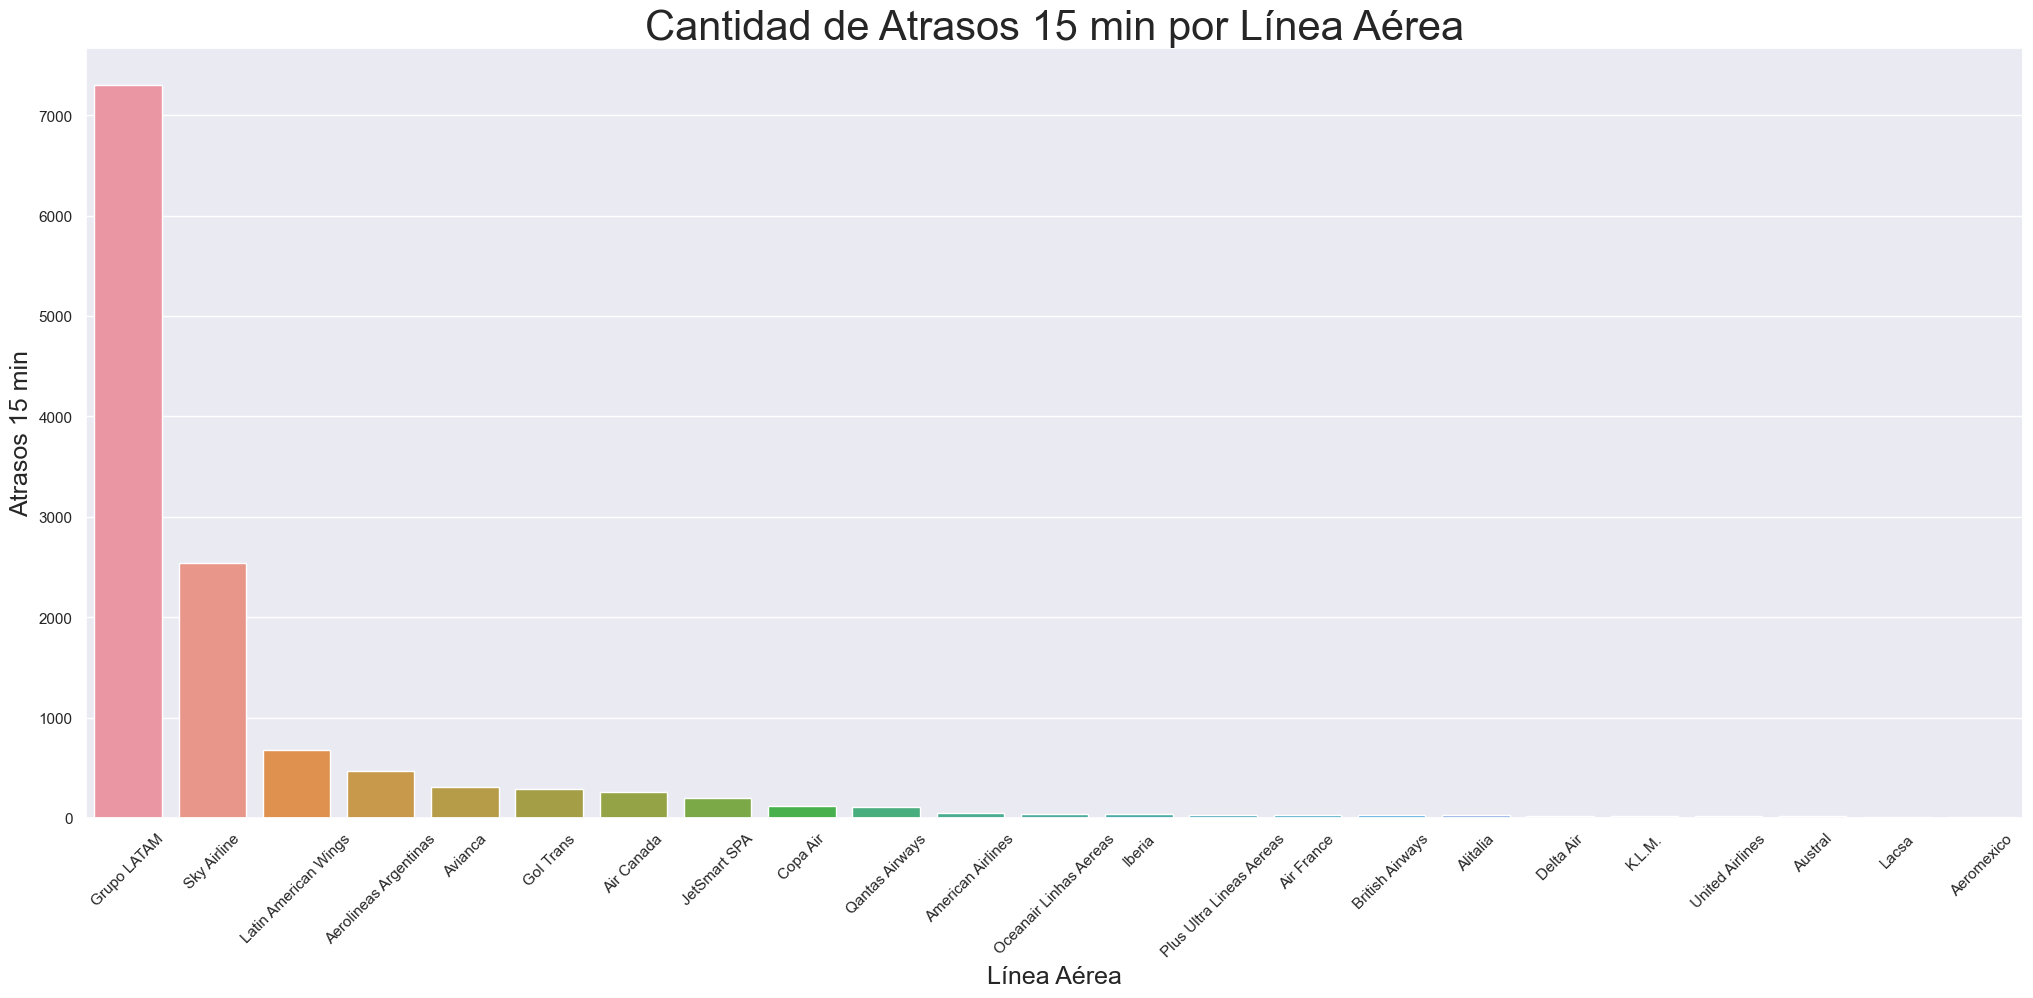

In [110]:
# Visualizar los frecuencia de atrasos por línea aérea

plt.figure(figsize=(25,10))
sns.barplot(data=atrasos_emp, x="OPERA", y='atraso_15')
plt.xlabel('Línea Aérea', fontsize=18);
plt.ylabel('Atrasos 15 min', fontsize=18);
plt.title('Cantidad de Atrasos 15 min por Línea Aérea', fontsize=30)
plt.xticks(rotation=45)
plt.show()

In [100]:
# Atrasos por línea aérea en relación a la cantidad de salidas


#Generación df cantidad de salidas por línea aérea
salidas = df.groupby('OPERA').agg({'atraso_15':'count'})
salidas.reset_index(inplace=True)
salidas = salidas.sort_values(by='atraso_15',ascending=False)
salidas.rename({'atraso_15':'cant_salidas'},axis=1,inplace=True)


atrasos_emp_porcentuales = pd.merge(atrasos_emp,salidas,how='left',on='OPERA')
atrasos_emp_porcentuales['porcentaje_atrasos'] = (atrasos_emp_porcentuales['atraso_15']/atrasos_emp_porcentuales['cant_salidas'])*100
atrasos_emp_porcentuales = atrasos_emp_porcentuales.sort_values(by='porcentaje_atrasos',ascending=False)

In [102]:
atrasos_emp_porcentuales.head()

,OPERA,atraso_15,cant_salidas,porcentaje_atrasos
13,Plus Ultra Lineas Aereas,30,49,61.224490
9,Qantas Airways,113,195,57.948718
6,Air Canada,258,565,45.663717
2,Latin American Wings,681,1674,40.681004
5,Gol Trans,287,806,35.607940


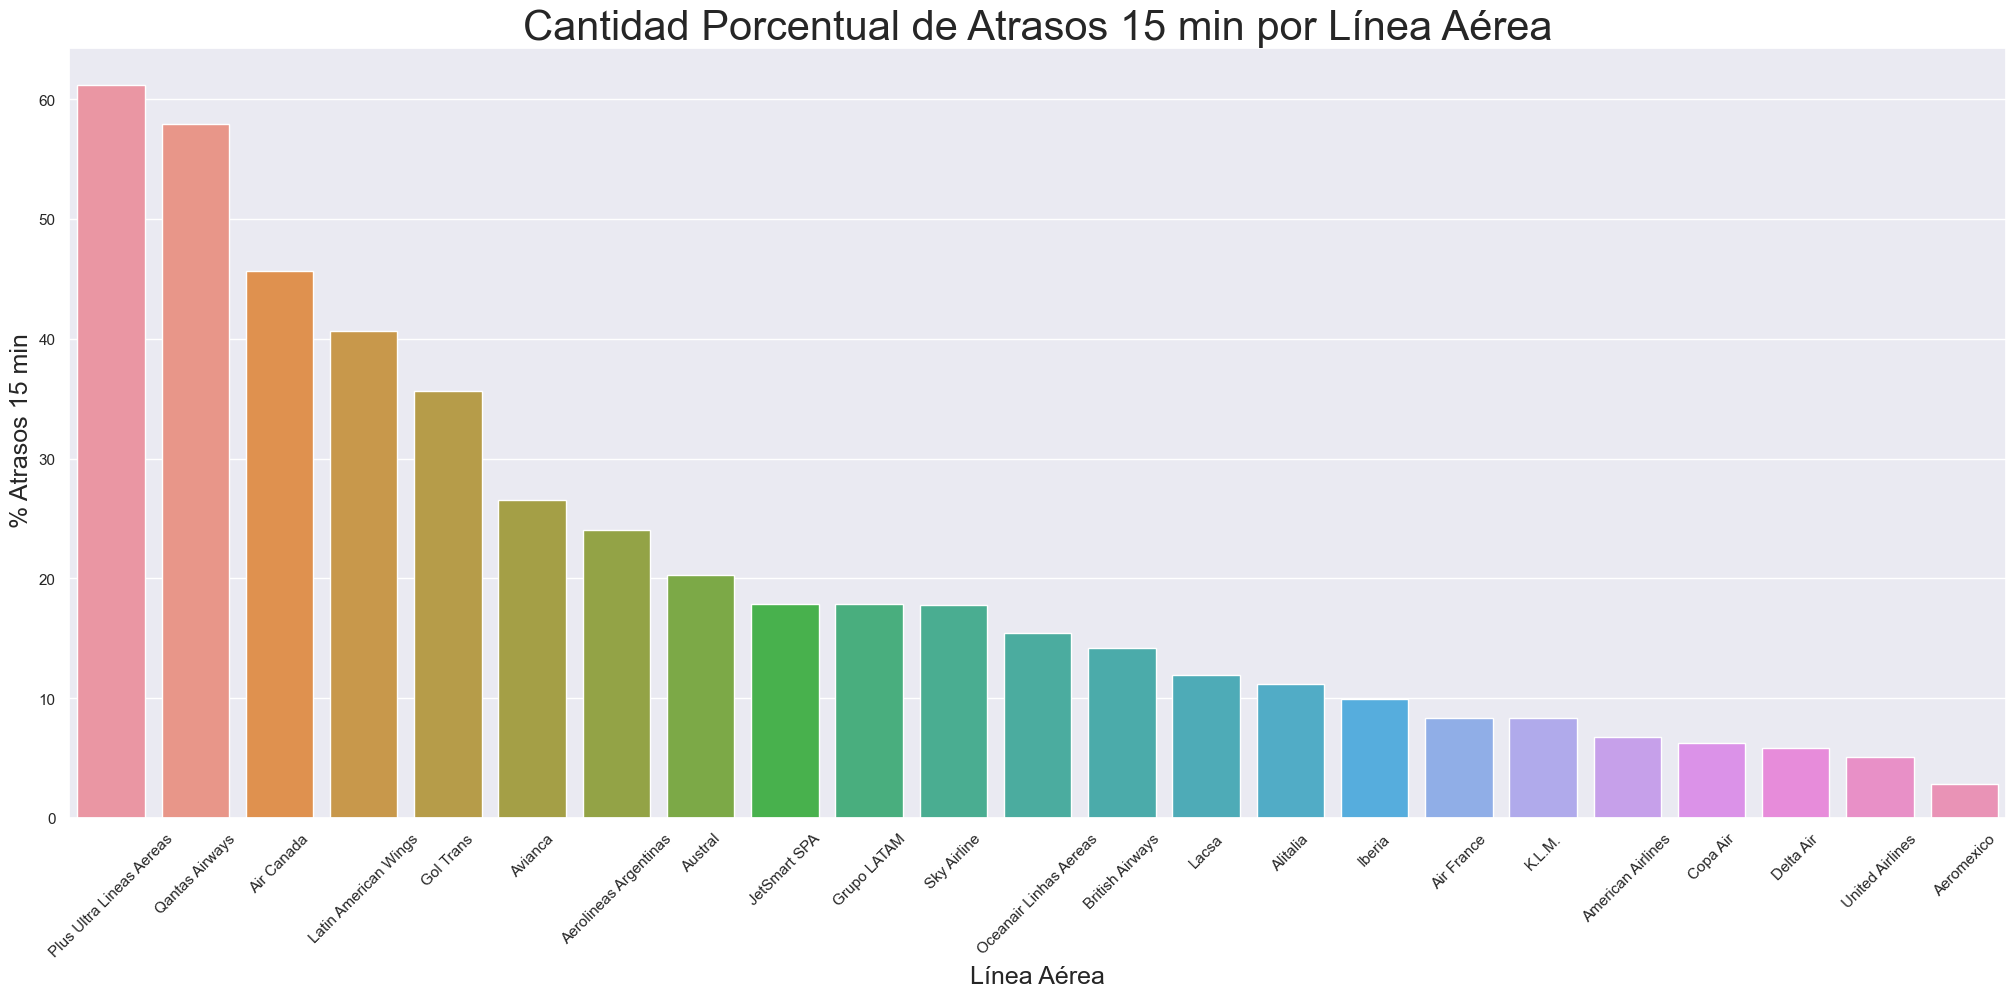

In [111]:
# Visualizar porcentaje de atrasos por línea aérea

plt.figure(figsize=(25,10))
sns.barplot(data=atrasos_emp_porcentuales, x="OPERA", y='porcentaje_atrasos')
plt.xlabel('Línea Aérea', fontsize=18);
plt.ylabel(' % Atrasos 15 min', fontsize=18);
plt.title('Cantidad Porcentual de Atrasos 15 min por Línea Aérea', fontsize=30)
plt.xticks(rotation=45)
plt.show()